# Global Matching

In [1]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
from math import floor,sqrt
import time

# Reduced Dimentional HOG Features

In [2]:
def reduced_HoG_Features(image, stride=8):
    '''Takes colored image as input'''
    image = np.array(image).astype(np.double)
    w,h,_ = image.shape
    
    epsilon = 0.00001 
    # unit vectors used to compute gradient orientation
    x_component = np.array([1.0000, 0.9397, 0.7660, 0.500, 0.1736, -0.1736, 
                            -0.5000, -0.7660, -0.9397]).astype(np.double)
    y_component = np.array([0.0000, 0.3420, 0.6428, 0.8660, 0.9848, 0.9848, 
                            0.8660, 0.6428, 0.3420]).astype(np.double)
    
    blocks = (w//stride, h//stride)
    histograms = np.zeros((w//stride, h//stride, 18))
    
    output_features = np.zeros((w//stride - 2, h//stride - 2, 31))
    
    visible_x = w//stride * stride
    visible_y = h//stride * stride
    
    for x in range(1,visible_x-1):
        for y in range(1,visible_y-1):
            magnitude = grad_x = grad_y = 0
            for k in range(3):
                grad_x_k = image[x+1][y][k] - image[x-1][y][k]
                grad_y_k = image[x][y+1][k] - image[x][y-1][k]
                magnitude_k = grad_x_k**2 + grad_y_k**2
                # Select the strongest gradient
                if magnitude < magnitude_k:
                    magnitude = magnitude_k
                    grad_x = grad_x_k
                    grad_y = grad_y_k
            magnitude = sqrt(magnitude)
            #Place the gradient in a bin of 20 degrees each
            best_dot = best_orientation = 0
            for o in range(9):
                dot = x_component[o] * grad_x + y_component[o] * grad_y
                if best_dot < dot:
                    best_dot = dot
                    best_orientation = o
                elif best_dot < -dot:
                    # This handles directed edges
                    best_dot = -dot
                    best_orientation = o + 9
            # add to 4 histograms around pixel using linear interpolation
            xp = (x+0.5)/stride - 0.5
            yp = (y+0.5)/stride - 0.5
            ixp = floor(xp)
            iyp = floor(yp)
            vx = xp-ixp
            vy = yp-iyp
            if ixp >=0 and iyp >=0: histograms[ixp][iyp][best_orientation] += (1-vx) * (1-vy) * magnitude 
            if ixp+1 < blocks[1] and iyp >=0: histograms[ixp+1][iyp][best_orientation] += vx * (1-vy) * magnitude
            if ixp >=0 and iyp+1 < blocks[0]: histograms[ixp][iyp+1][best_orientation] += (1-vx) * vy * magnitude 
            if ixp+1 < blocks[1] and iyp+1 < blocks[0]: histograms[ixp+1][iyp+1][best_orientation] += vx * vy * magnitude 
    #normalizing factors
    norm_fac = np.sum(histograms,axis=2)
    
    #write reduced features
    out_x = w//stride - 2
    out_y = h//stride - 2
    for x in range(out_x):
        for y in range(out_y):
            n1 = 1.0/sqrt(norm_fac[x+1][y+1]+norm_fac[x+2][y+1]+norm_fac[x+1][y+2]+norm_fac[x+2][y+2]+epsilon)
            n2 = 1.0/sqrt(norm_fac[x+1][y]+norm_fac[x+2][y]+norm_fac[x+1][y+1]+norm_fac[x+2][y+1]+epsilon)
            n3 = 1.0/sqrt(norm_fac[x][y+1]+norm_fac[x+1][y+1]+norm_fac[x][y+2]+norm_fac[x+1][y+2]+epsilon)
            n4 = 1.0/sqrt(norm_fac[x][y]+norm_fac[x+1][y]+norm_fac[x][y+1]+norm_fac[x+1][y+1]+epsilon)
            t1 = t2 = t3 = t4 = 0
            for o in range(18):
                h1 = min(histograms[x+1][y+1][o] * n1, 0.2)
                h2 = min(histograms[x+1][y][o] * n2, 0.2)
                h3 = min(histograms[x][y+1][o] * n3, 0.2)
                h4 = min(histograms[x][y][o] * n4, 0.2)
                output_features[x][y][o] = 0.5 * (h1+h2+h3+h4)
                t1 += h1
                t2 += h2
                t3 += h3
                t4 += h4
            for o in range(9):
                h1 = min((histograms[x+1][y+1][o] + histograms[x+1][y+1][o+9]) * n1, 0.2)
                h2 = min((histograms[x+1][y][o] + histograms[x+1][y][o+9]) * n2, 0.2)
                h3 = min((histograms[x][y+1][o] + histograms[x][y+1][o+9]) * n3, 0.2)
                h4 = min((histograms[x][y][o] + histograms[x][y][o+9]) * n4, 0.2)
                output_features[x][y][o+18] = 0.5 * (h1+h2+h3+h4)
            output_features[x][y][27] = 0.2357 * t1
            output_features[x][y][28] = 0.2357 * t2
            output_features[x][y][29] = 0.2357 * t3
            output_features[x][y][30] = 0.2357 * t4
    return output_features

# img = cv2.imread('./singapore.jpg')
# img = cv2.resize(img,(256,256),cv2.INTER_CUBIC)
# features = reduced_HoG_Features(img)
# print(features.shape)

## Stacking of neigbouring pixels (2X2) for robustness

In [3]:
def stack_neigbours(features):
    W,H,_ = features.shape
    W = W - 1
    H = H - 1
    descriptors = np.zeros((124,W * H))
    for i in range(W):
        for j in range(H):
            n = i * H + j
            descriptors[:31,n] = np.uint8(features[i,j] * 255)
            descriptors[31:62,n] = np.uint8(features[i+1,j] * 255)        
            descriptors[62:93,n] = np.uint8(features[i,j+1] * 255)        
            descriptors[93:,n] = np.uint8(features[i+1,j+1] * 255)

#     print(descriptors.shape)
    return descriptors

# Visual Words Dictionary

In [4]:
words = np.load('words.npy')
print(words.shape)

(124, 300)


In [5]:
def word2vec(descriptors):
    word_histogram = np.zeros(300).astype(np.int16)
    n = descriptors.shape[1]
    for i in range(n):
        distances = np.sum((words.T - descriptors[:,i])**2, axis=1)
        word_histogram[np.argmin(distances)] += 1
    return word_histogram

# Pipeline HOG

In [6]:
def hog_pipeline(image):
    features = reduced_HoG_Features(image)
    descriptors = stack_neigbours(features)
    word_histogram = word2vec(descriptors)
    return word_histogram
# img = cv2.imread('./input_images/singapore.jpg')
# img = cv2.resize(img,(256,256),cv2.INTER_CUBIC)
# a = hog_pipeline(img)
# print(a)

# Pyramidal pipeline

In [7]:
def pyramid_hog(image,levels=2):
    image = cv2.resize(image,(256,256),cv2.INTER_CUBIC)
    w,h,_ = image.shape
    descriptors = []
    for level in range(levels+1):
        level_descriptors = []
        
        for i in range(2**level):
            for j in range(2**level):
                image_part = image[i*(w//(2**level)):(i+1)*(w//(2**level)),j*(h//(2**level)):(j+1)*(h//(2**level))]
                temp = hog_pipeline(image_part)
                level_descriptors.append(temp)
        
        descriptors.append(level_descriptors)
    return descriptors

# img = cv2.imread('./input_images/singapore.jpg')
# a = pyramid_hog(img)

# Similarity Metric - Histogram intersection

In [8]:
def histogram_intersection(hist_A, hist_B):
    return np.sum(np.minimum(hist_A, hist_B))

def pyramid_intersection(pyramid_hist_A, pyramid_hist_B):
    levels = len(pyramid_hist_A)
    score = 0
    for level in range(levels):
        weight = 1.0/2**(levels-level)
        for region in range(2**level):
            similarity = histogram_intersection(pyramid_hist_A[level][region],pyramid_hist_B[level][region])
            score += weight * similarity
    return score

# Video reader

In [9]:
def videoReader(video,play=False):
    cap = cv2.VideoCapture(video)
    if (cap.isOpened() == False): 
        print("Error opening video stream or file")
    if play:
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == True:
                cv2.imshow('Frame',frame)
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            else:
                break
        cap.release()
        cv2.destroyAllWindows()
    return cap

In [10]:
def processVideo(path_video, width=256, height=256,samples_per_video=5):
    video = videoReader(path_video)
    
    numberOfFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    video_width  = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print("Video info", path_video,"Frames",numberOfFrames,"Dimensions",video_width,video_height)
    
    video_descriptors = []
    idx = np.round(np.linspace(0, numberOfFrames-1, samples_per_video)).astype(int)
    for i in range(samples_per_video):
        video.set(cv2.CAP_PROP_POS_FRAMES, idx[i])
        _, frame = video.read()
#         resized_frame = cv2.resize(frame,(width,height),cv2.INTER_CUBIC)
        frame_descriptor = pyramid_hog(frame)
        video_descriptors.append(frame_descriptor)
        
    return np.array(video_descriptors)

# video_path = '../videos_h264//dubai.avi'
# a = processVideo(video_path,256,256)
# print(a)

# Iterate over all videos

In [11]:
from os import listdir
from os.path import isfile, join
videos_dir = '../videos_h264/'
videos_paths = [videos_dir + f for f in listdir(videos_dir) if isfile(join(videos_dir, f))]
print('Number of videos:',len(videos_paths))

Number of videos: 463


# Save as pickle file

In [12]:
# print(time.time())
# count = 0
# total = len(videos_paths)
# timeLapseHOGs = {}
# for video_path in videos_paths:
#     if video_path == '../videos_h264/Thumbs.db':
#         continue
#     if video_path == '../videos_h264/04_16_2012_16_17_54.mp4':
#         continue
#     if video_path == '../videos_h264/ice_sheet_sunset2.mp4':
#         continue
#     videoHOG = processVideo(video_path)
#     timeLapseHOGs[video_path] = videoHOG
#     count += 1
#     print('Video processed',count,'/',total)
# print(time.time())
# with open('timelapseHOG.pickle', 'wb') as handle:
#     pickle.dump(timeLapseHOGs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
with open('timelapseHOG.pickle', 'rb') as handle:
    timeLapseVideoHOGs = pickle.load(handle)

# Search for best video

In [14]:
def checkVideo(image_descriptor,video_descriptors,samples_per_video=5):
    max_similarity = 0
    for i in range(samples_per_video):
        similarity = pyramid_intersection(video_descriptors[i], image_descriptor)
        if max_similarity < similarity:
            max_similarity = similarity
    return max_similarity

def findBestVideo(image):
#     resized_image = cv2.resize(image,(256,256),cv2.INTER_CUBIC)
#     image_descriptor = hog_pipeline(resized_image)
    image_descriptor = pyramid_hog(image)
    
    max_index = None
    max_similarity = 0
    similarities_array = []
    
    count = 0
    total = len(videos_paths)
    for video_path,video_descriptor in timeLapseVideoHOGs.items():
        similarity = checkVideo(image_descriptor,video_descriptor)
        similarities_array.append((similarity,video_path))
        if similarity > max_similarity:
            max_similarity = similarity
            max_index = video_path
        count += 1
        print(count,'/',total,'\t',similarity,'\t',video_path,)
    
    print(max_similarity)
    print(max_index)
    similarities_array.sort()
    
    return similarities_array[-6:]

# Load image

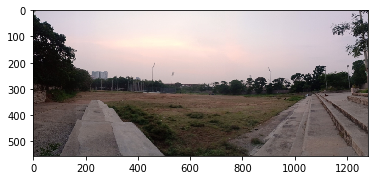

In [15]:
img = cv2.imread('./input_images/felicity.jpeg')
plt.imshow(img[:,:,::-1])

In [16]:
print(time.time())
bestVideos = findBestVideo(img)
print(time.time())

1587543772.1215897
1 / 463 	 156.75 	 ../videos_h264/04_16_2012_16_36_28.mp4
2 / 463 	 164.625 	 ../videos_h264/TimeLapseofSunsetHDRFX_7.mp4
3 / 463 	 168.625 	 ../videos_h264/city.mp4
4 / 463 	 159.625 	 ../videos_h264/Fort_Lauderdale_Time_lapse.mp4
5 / 463 	 143.75 	 ../videos_h264/4006_2.mp4
6 / 463 	 145.25 	 ../videos_h264/24__Hr_Time_Lapse.mp4
7 / 463 	 152.625 	 ../videos_h264/Timelapse___Puerto_de_Malaga.mp4
8 / 463 	 145.375 	 ../videos_h264/59399399.mp4
9 / 463 	 149.75 	 ../videos_h264/24_Hour_Boston_Timelapse__Longwood_Medical_Area_.mp4
10 / 463 	 157.0 	 ../videos_h264/cape_town_moonrise_time_lapse_1280x720.mp4
11 / 463 	 126.75 	 ../videos_h264/80496929.mp4
12 / 463 	 155.0 	 ../videos_h264/Sunset_over_the_Dubai_skyline_timelapse_HD_1080p.mp4
13 / 463 	 174.0 	 ../videos_h264/40025.mp4
14 / 463 	 138.25 	 ../videos_h264/Good_Morning_Hong_Kong_from_another_angle.mp4
15 / 463 	 157.875 	 ../videos_h264/83485476.mp4
16 / 463 	 136.25 	 ../videos_h264/51386887.mp4
17 / 463 	 

274 / 463 	 143.75 	 ../videos_h264/Palma_de_Mallorca_s_Bay__a_24_hour_Timelapse.mp4
275 / 463 	 142.875 	 ../videos_h264/04_16_2012_16_10_29.mp4
276 / 463 	 150.0 	 ../videos_h264/Manhattan_Derecho_2012_07_26.mp4
277 / 463 	 160.125 	 ../videos_h264/SandyTL_Time_Lapse_of_Sandy_Hitting_NYC.mp4
278 / 463 	 163.125 	 ../videos_h264/NYC_TL_SHOT_1.mp4
279 / 463 	 149.5 	 ../videos_h264/24_hours_time_lapse.mp4
280 / 463 	 158.75 	 ../videos_h264/Time_lapse___24_hours_from_the_apartment__2_.mp4
281 / 463 	 122.5 	 ../videos_h264/First_time_lapse.mp4
282 / 463 	 161.375 	 ../videos_h264/91366222.mp4
283 / 463 	 171.25 	 ../videos_h264/OpenfootageNETsunsetgarda720p.mp4
284 / 463 	 146.125 	 ../videos_h264/40328.mp4
285 / 463 	 155.0 	 ../videos_h264/Snow_Day_February_2009___24_hour_Time_Lapse.mp4
286 / 463 	 163.625 	 ../videos_h264/24_hours_Time_lapse_of_Norco_Hills_weather_Mar_25_2012.mp4
287 / 463 	 175.5 	 ../videos_h264/Burj_Khalifa_Sunset_TimeLapse.mp4
288 / 463 	 146.125 	 ../videos_h26

In [17]:
print(bestVideos)
for i in bestVideos:
    print(i[0],i[1])
    cap = videoReader(i[1],play=True)

[(184.25, '../videos_h264/Kuala_Lumpur_Time_Lapse__KL_Sentral_HD.mp4'), (186.0, '../videos_h264/TL0000AA61.mp4'), (186.25, '../videos_h264/4008_15.mp4'), (188.625, '../videos_h264/HD_Time_Lapse_Afternoon.mp4'), (190.25, '../videos_h264/518.mp4'), (194.5, '../videos_h264/1170691376.mp4')]
184.25 ../videos_h264/Kuala_Lumpur_Time_Lapse__KL_Sentral_HD.mp4
186.0 ../videos_h264/TL0000AA61.mp4
186.25 ../videos_h264/4008_15.mp4
188.625 ../videos_h264/HD_Time_Lapse_Afternoon.mp4
190.25 ../videos_h264/518.mp4
194.5 ../videos_h264/1170691376.mp4


In [18]:
# img_a = cv2.imread('./input_images/mountains.jpg')
# a = pyramid_hog(img_a)
# # img_a = cv2.resize(img_a,(256,256))
# # a = hog_pipeline(img_a)
# img_b = cv2.imread('./input_images/minar.jpg')
# b = pyramid_hog(img_b)
# # img_b = cv2.resize(img_b,(256,256))
# # b = hog_pipeline(img_b)
# print(pyramid_intersection(a,b))
# # print(histogram_intersection(a,b))

# Frame selection:

In [19]:
def ImageHistogram(image, nbins=256):
    hist_b = cv2.calcHist([image],[0],None,[nbins],[0,256]) 
    hist_g = cv2.calcHist([image],[1],None,[nbins],[0,256]) 
    hist_r = cv2.calcHist([image],[2],None,[nbins],[0,256])
    
    hist_des = np.vstack((hist_r,hist_g,hist_b))
    hist_des = hist_des/image.size
    return hist_des

In [20]:
def best_distribution_frame(image,video):
    '''Search for best frame given a particular video'''
    image_descriptor = ImageHistogram(image)
    
    min_distance = 100000
    min_index = 0
    numberOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    sampling_rate = numberOfFrames//100

    for i in range(0,numberOfFrames,sampling_rate):
        video.set(cv2.CAP_PROP_POS_FRAMES, i)
        res, frame = video.read()
        frame_descriptor = ImageHistogram(frame)
        distance = np.linalg.norm(frame_descriptor - image_descriptor)
        if min_distance > distance:
            min_distance = distance
            min_index = i
    
    # Resizing the matched frame to image size, for future operations
    video.set(cv2.CAP_PROP_POS_FRAMES, min_index)
    res, matched_frame = video.read()
    matched_frame = cv2.resize(matched_frame,(image.shape[1],image.shape[0]),cv2.INTER_CUBIC)
    return matched_frame, min_index,min_distance

Matched frame: 36  with distance metric as  0.027078368047111643
Matched frame: 288  with distance metric as  0.031658433251399325
Matched frame: 200  with distance metric as  0.04628524930080952
Matched frame: 5751  with distance metric as  0.031659677004039884
Matched frame: 147  with distance metric as  0.04673786392024857
Matched frame: 7998  with distance metric as  0.02316108626982578
Time taken: 114.99204301834106


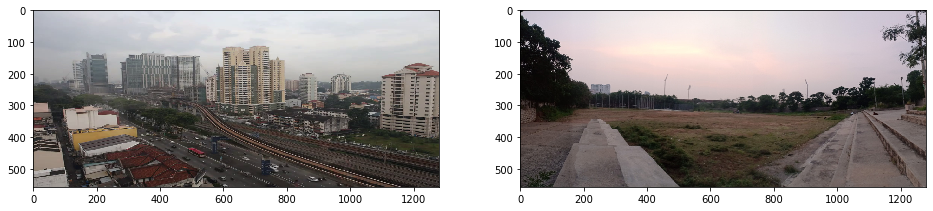

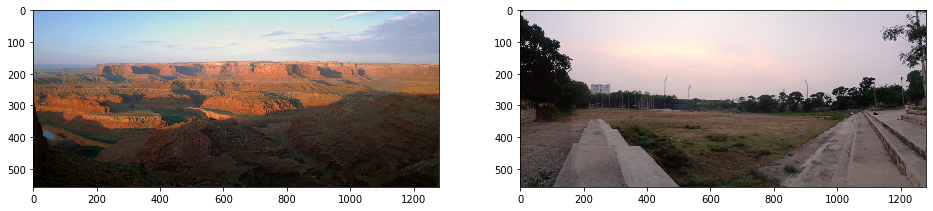

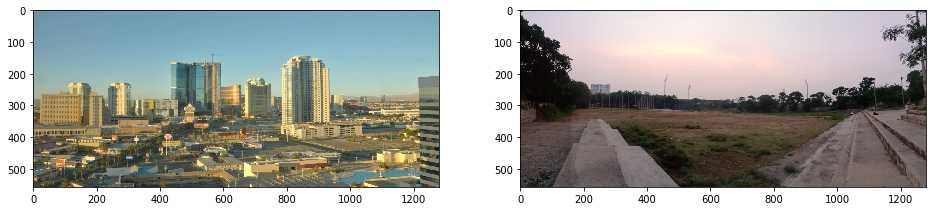

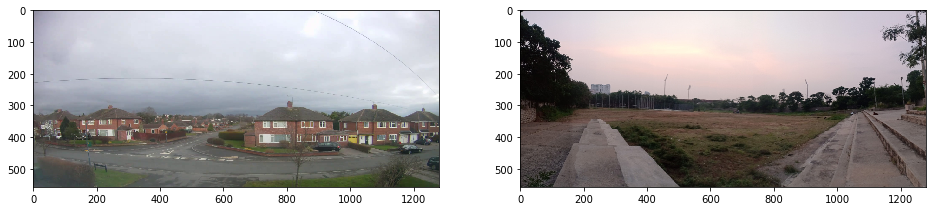

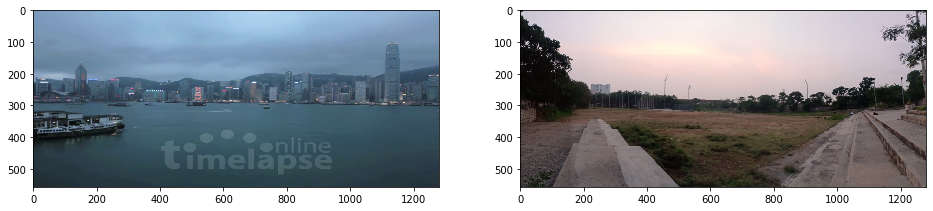

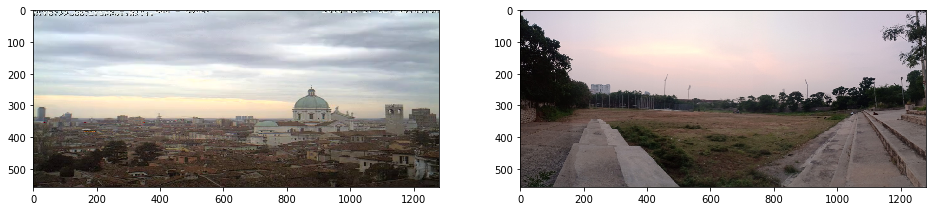

In [21]:
a = time.time()
final_video = None
final_video_quality = 10000
for _,video in bestVideos:
    cap = videoReader(video)
    matched_frame, matched_frame_index, match_quality = best_distribution_frame(img,cap)
    print("Matched frame:",matched_frame_index, " with distance metric as ", match_quality)
    if final_video_quality > match_quality:
        final_video_quality = match_quality
        final_video = video
    plt.figure(figsize=(16,16))
    plt.subplot(1,2,1)
    plt.imshow(matched_frame[...,::-1])
    plt.subplot(1,2,2)
    plt.imshow(img[...,::-1])
print("Time taken:",time.time() - a)

In [39]:
cap = videoReader(final_video)
print('../'+final_video)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(length)
cap2 = videoReader(final_video,play=True)

../../videos_h264/1170691376.mp4
9335
../videos_h264/1170691376.mp4
0.0


In [60]:
frame_time = [5,14]
total_time = [6,13]
frame_number = (frame_time[0]*60+frame_time[1])/(total_time[0]*60+total_time[1]) * length
frame_number = int(frame_number)
print(frame_number + 1)

7859


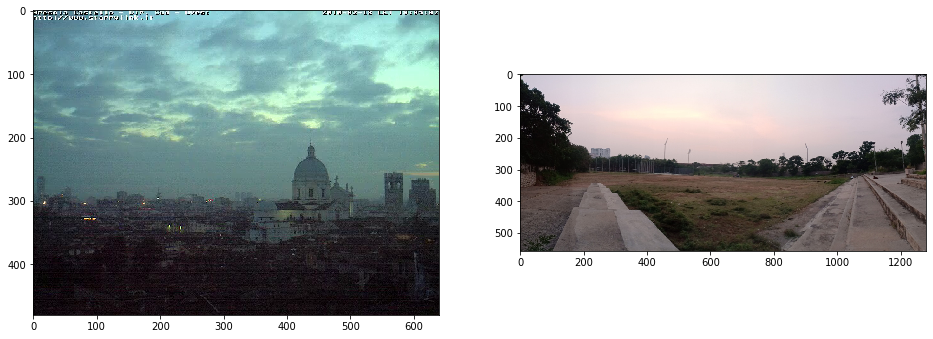

In [61]:
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
_, frame = cap.read()
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(frame[...,::-1])
plt.subplot(1,2,2)
plt.imshow(img[...,::-1])